# ML 6: Width visualisation on whole plate

In [86]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

The goal of this notebook is to validate graphically that the model is working on real edges in the network

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from amftrack.util.sys import (
    get_current_folders,
    update_plate_info,
    test_path
)

2022-08-18 18:01:20.464809: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi951/linux64/lib
2022-08-18 18:01:20.464835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/felix/Wks/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


FileNotFoundError: [Errno 2] No such file or directory: '/media/felix/AMFtopology02/storage/models'

In [2]:
from amftrack.util.sys import storage_path
from amftrack.util.geometry import generate_index_along_sequence
from amftrack.pipeline.functions.image_processing.extract_width_fun import compute_edge_width_profile, extract_section_profiles_for_edge

2022-06-20 17:37:45.842229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/cv2/../../lib64::/opt/gurobi951/linux64/lib
2022-06-20 17:37:45.842255: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-20 17:37:45.842280: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (felix-XPS-13-9360): /proc/driver/nvidia/version does not exist
2022-06-20 17:37:45.842756: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate c

In [85]:
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    Node,
    Edge,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_width,
)

### General parameters

In [4]:
model_name = "test"
directory = test_path
plate_name = "20220330_2357_Plate19"

### Experiment object setup

In [5]:
update_plate_info(directory)
folder_df = get_current_folders(directory)
selected_df = folder_df.loc[folder_df["folder"] == plate_name]
i = 0
exp = Experiment(directory)
exp.load(selected_df, suffix="")
exp.load_tile_information(0)

analysed:   0%|          | 0/25 [00:00<?, ?it/s]

2022-03-30 23:57:00
1
1


### Model overview

In [ ]:
save_path = os.path.join(storage_path, "models", "20220601-default")
model = keras.models.load_model(save_path)

In [148]:
model.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 120, 1)]          0         
                                                                 
 rescaling_26 (Rescaling)    (None, 120, 1)            0         
                                                                 
 conv1 (Conv1D)              (None, 37, 300)           3900      
                                                                 
 conv2 (Conv1D)              (None, 10, 320)           768320    
                                                                 
 flatten_26 (Flatten)        (None, 3200)              0         
                                                                 
 dense1 (Dense)              (None, 340)               1088340   
                                                                 
 dense2 (Dense)              (None, 220)               750

### Define model and slice extraction parameters

In [6]:
width_fun = lambda edge: compute_edge_width_profile(exp, 0, edge, resolution=4, offset=5)
f = lambda n: generate_index_along_sequence(
        n, resolution=4, offset=5
    )
f_profiles = lambda edge: extract_section_profiles_for_edge(exp, 0, edge, resolution = 5, offset = 4, step = 3)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

## 0/ General visualisation

### Full plate

<IPython.core.display.Javascript object>


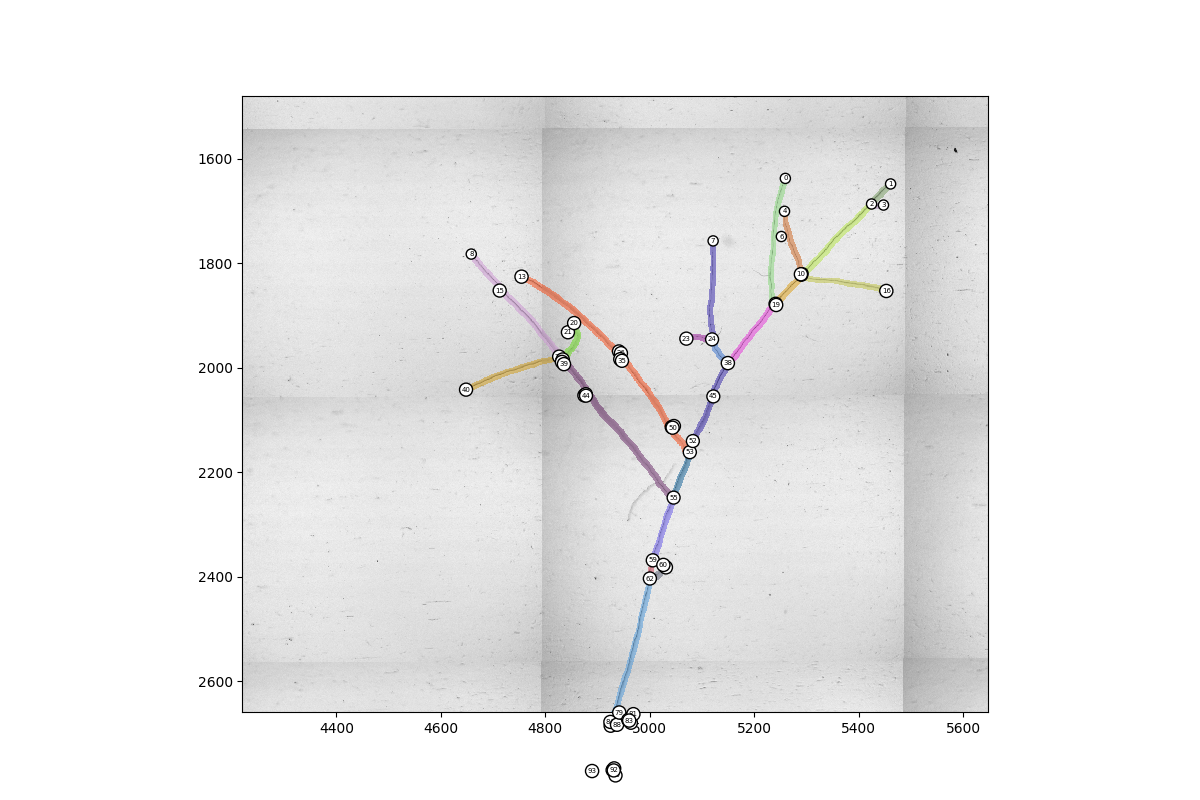

In [35]:
%matplotlib notebook
plot_full_image_with_features(exp, 0, downsizing = 5, dilation = 10, edges = get_all_edges(exp, 0), nodes = get_all_nodes(exp, 0))

### Chosen edges

In [8]:
appex_edge_1 = [429, 416] # very small
appex_edge_2 = [12, 16]
medium_edge_1 = [417, 365]
big_edge_1 = [750, 624]

In [9]:
edges_nodes = [appex_edge_1, appex_edge_2, medium_edge_1, big_edge_1]

In [10]:
edges = []
for edge in edges_nodes:
    edges.append(get_edge_from_node_labels(exp, 0, edge[0], edge[1]))

In [11]:
edges

[Edge(429,416), Edge(12,16), Edge(417,365), Edge(624,750)]

### Plot chosen edges on the original image

In [61]:
begin_nodes = [edge.begin for edge in edges]
end_nodes = [edge.end for edge in edges]
nodes = [node for l in [begin_nodes, end_nodes] for node in l]

<IPython.core.display.Javascript object>


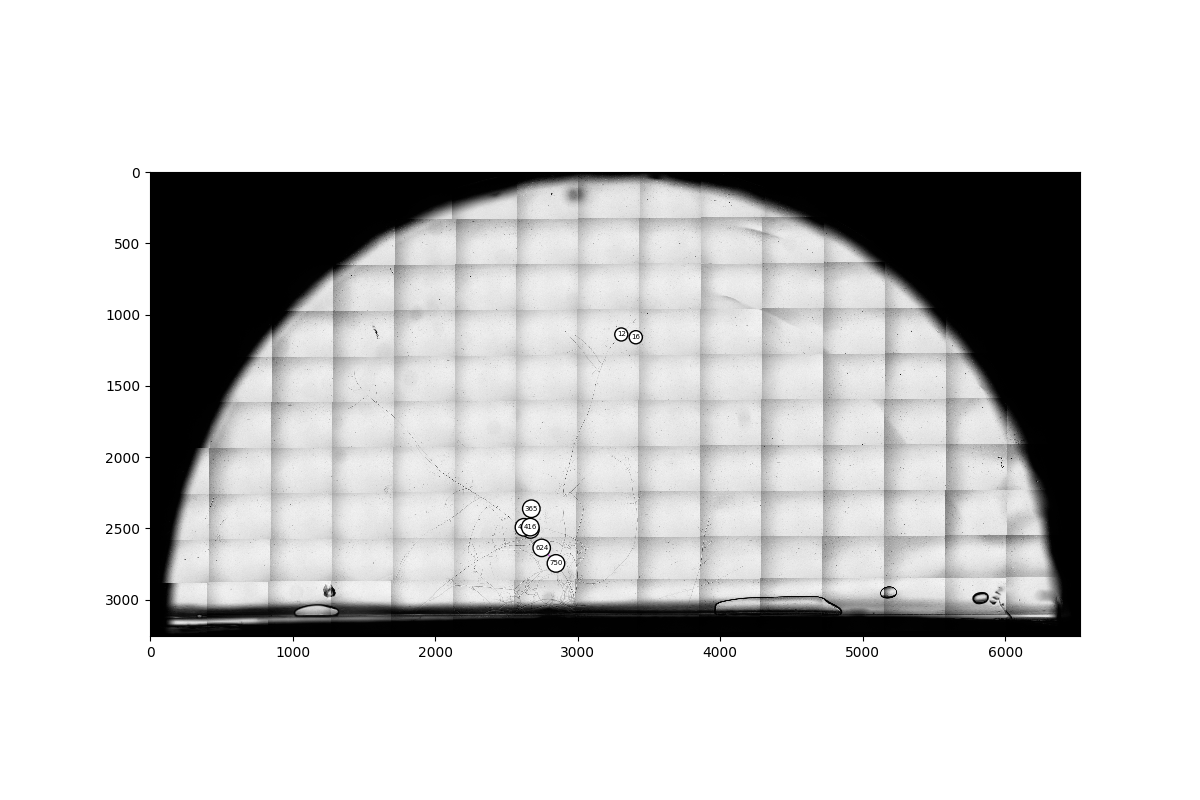

In [77]:
%matplotlib notebook
plot_full_image_with_features(exp, 0, downsizing = 8, dilation = 10, edges = edges, nodes = nodes)

## 1/ Visualize extracted slices

In [63]:
edge = edges[0]

f = lambda n: generate_index_along_sequence(
        n, resolution=4, offset=5
    )

<IPython.core.display.Javascript object>


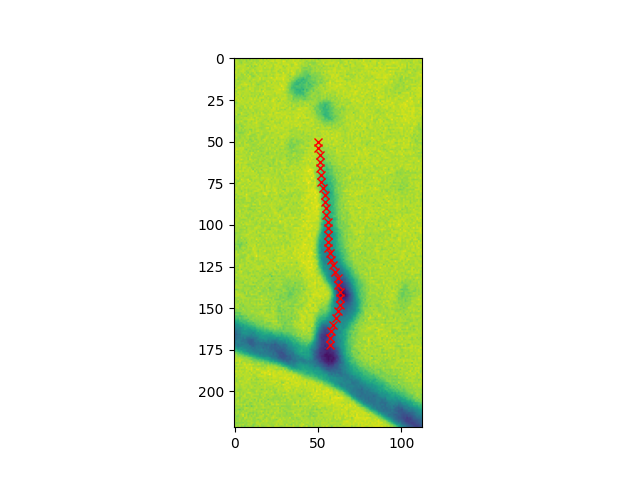

In [74]:
plot_edge_cropped(edge, 0, mode=3, f=f)

In [80]:
slices, coords1, coords2 = f_profiles(edge)
plt.imshow(slices)

## 2/ Visualize profiles

### Small edge 1

In [131]:
edge = edges[0]

In [132]:
widths = np.squeeze(width_fun(edge))

#### Profile

<IPython.core.display.Javascript object>


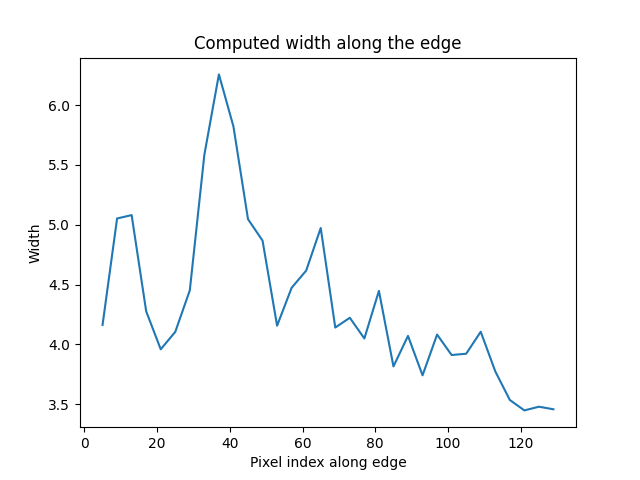

Text(0.5, 1.0, 'Computed width along the edge')

In [87]:
plt.plot(f(len(edge.pixel_list(0))), list(widths))
plt.xlabel("Pixel index along edge")
plt.ylabel("Width")
plt.title("Computed width along the edge")

In [80]:
slices, coords1, coords2 = f_profiles(edge)
plt.imshow(slices)

### Small edge 2

In [133]:
edge = edges[1]

In [92]:
widths = np.squeeze(width_fun(edge))

<IPython.core.display.Javascript object>


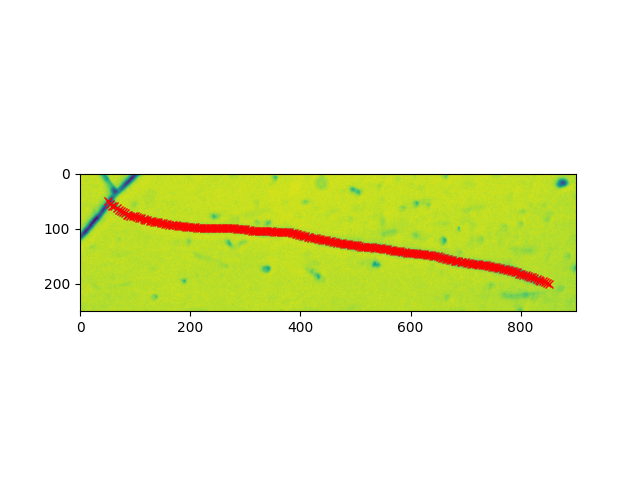

In [90]:
plot_edge_cropped(edge, 0, mode=3, f=f)

<IPython.core.display.Javascript object>


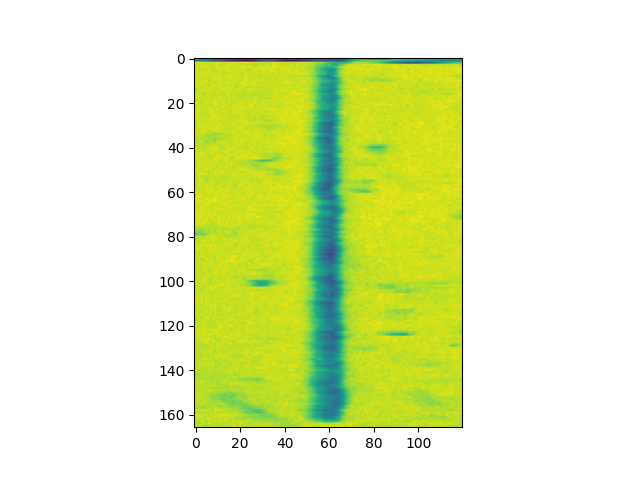

In [134]:
slices, coords1, coords2 = f_profiles(edge)
plt.imshow(slices)

#### Profile

<IPython.core.display.Javascript object>


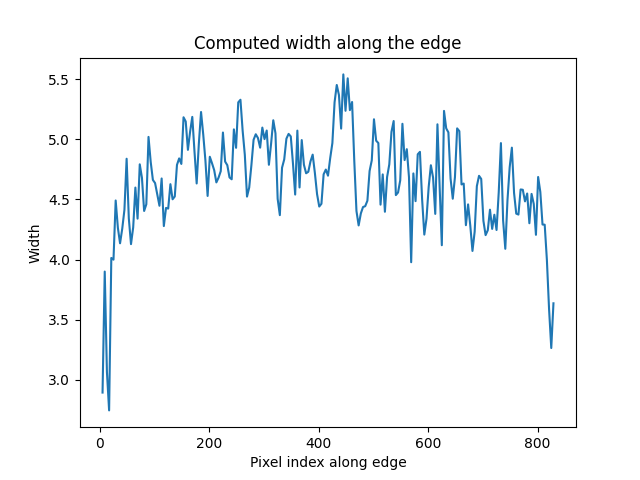

Text(0.5, 1.0, 'Computed width along the edge')

In [93]:
plt.plot(f(len(edge.pixel_list(0))), list(widths))
plt.xlabel("Pixel index along edge")
plt.ylabel("Width")
plt.title("Computed width along the edge")

### Medium edge

In [136]:
edge = edges[2]

In [137]:
widths = np.squeeze(width_fun(edge))

<IPython.core.display.Javascript object>


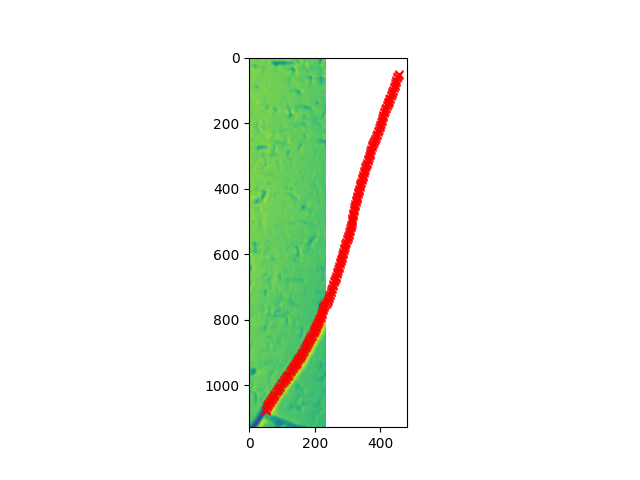

In [97]:
plot_edge_cropped(edge, 0, mode=3, f=f)

<IPython.core.display.Javascript object>


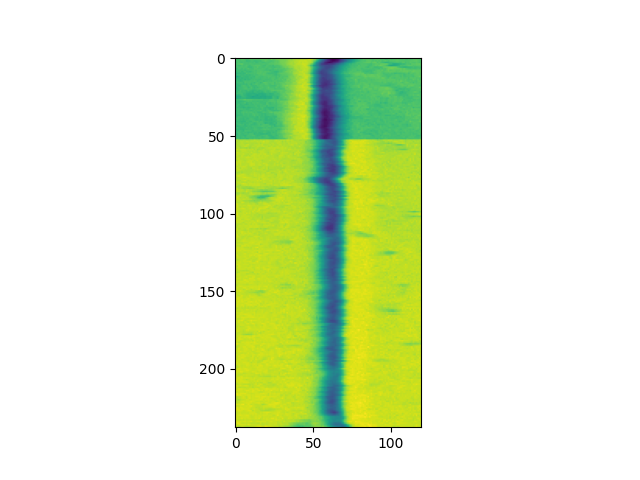

In [138]:
slices, coords1, coords2 = f_profiles(edge)
plt.imshow(slices)

#### Profile

<IPython.core.display.Javascript object>


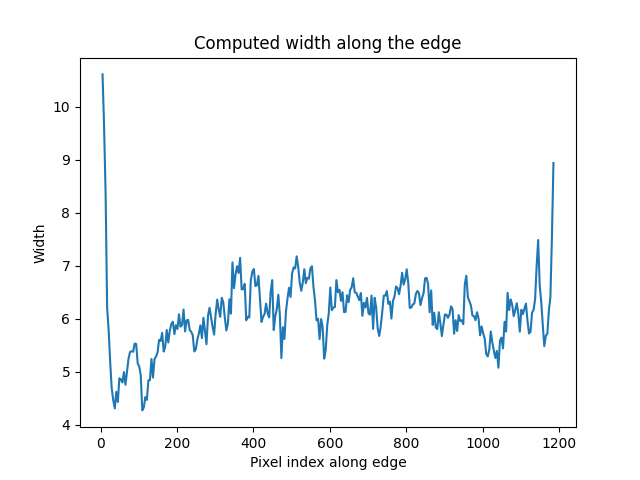

Text(0.5, 1.0, 'Computed width along the edge')

In [98]:
plt.plot(f(len(edge.pixel_list(0))), list(widths))
plt.xlabel("Pixel index along edge")
plt.ylabel("Width")
plt.title("Computed width along the edge")

### Big edge

In [139]:
edge = edges[3]

In [125]:
widths = np.squeeze(width_fun(edge))

<IPython.core.display.Javascript object>


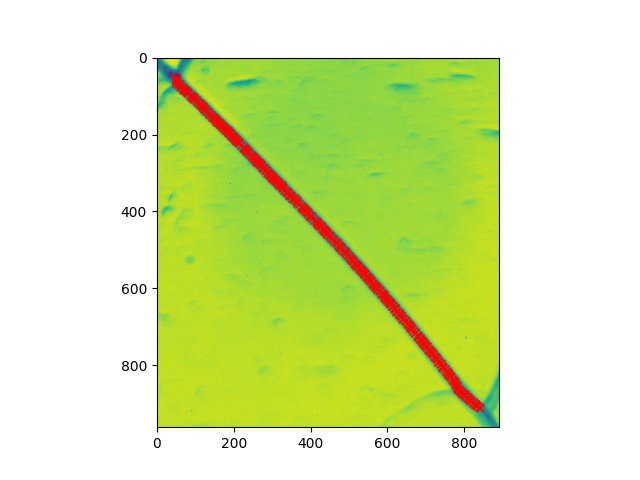

In [126]:
plot_edge_cropped(edge, 0, mode=3, f=f)

<IPython.core.display.Javascript object>


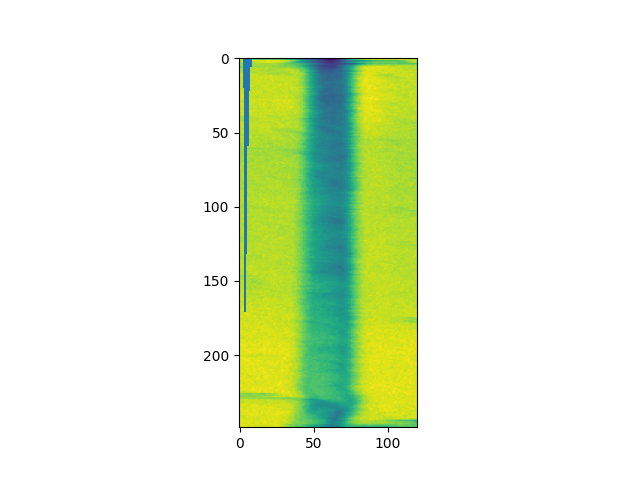

In [140]:
slices, coords1, coords2 = f_profiles(edge)
plt.imshow(slices)

#### Profile

<IPython.core.display.Javascript object>


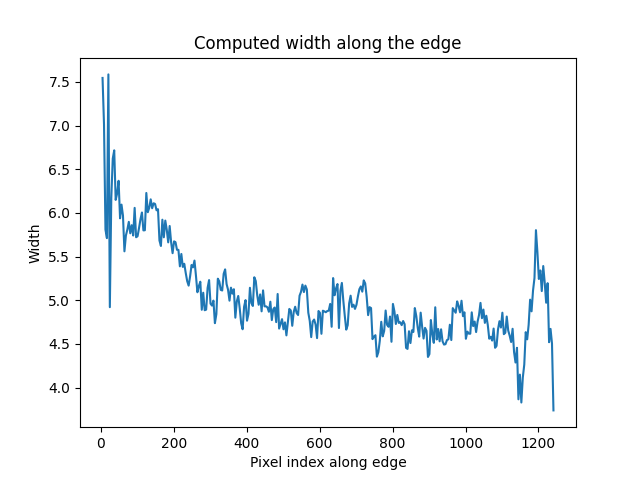

Text(0.5, 1.0, 'Computed width along the edge')

In [129]:
plt.plot(f(len(edge.pixel_list(0))), list(widths))
plt.xlabel("Pixel index along edge")
plt.ylabel("Width")
plt.title("Computed width along the edge")

#### Rolling average

<IPython.core.display.Javascript object>


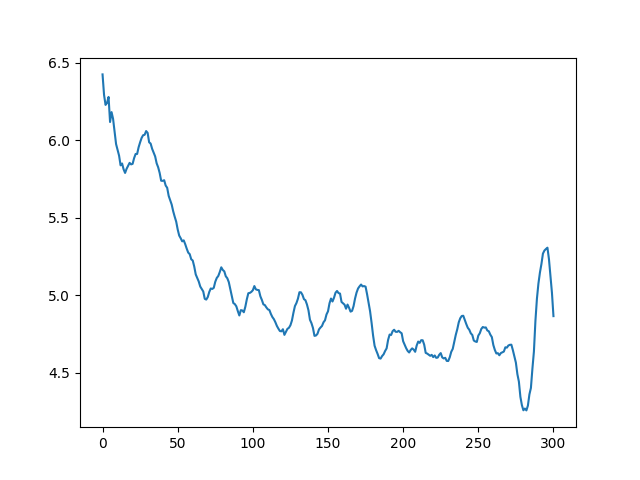

In [130]:
plt.plot(moving_average(widths,10))

### Mean and average scores

In [115]:
means = []
medians = []
lengths = []
std = []
for edge in edges:
    widths = width_fun(edge)
    means.append(np.mean(widths))
    medians.append(np.median(widths))
    lengths.append(len(widths))
    std.append(np.std(widths))

#### Mean

In [116]:
print(means)

[4.346799, 4.650715, 6.085707, 5.040114]


#### Median

In [117]:
print(medians)

[4.148839, 4.6811194, 6.0908117, 4.9047456]


#### Std

In [118]:
print(std)

[0.67636424, 0.41383502, 0.6996603, 0.5330719]


#### Length

In [120]:
print(lengths)

[32, 207, 296, 310]


## 3/ Visualize full plate

In [22]:
edges = get_all_edges(exp, 0)
medians = {}
mean = {}
for edge in edges:
    if len(edge.pixel_list(0))>100:
        widths = width_fun(edge)
        medians[edge] = np.median(widths)

1


### Histogram

<IPython.core.display.Javascript object>


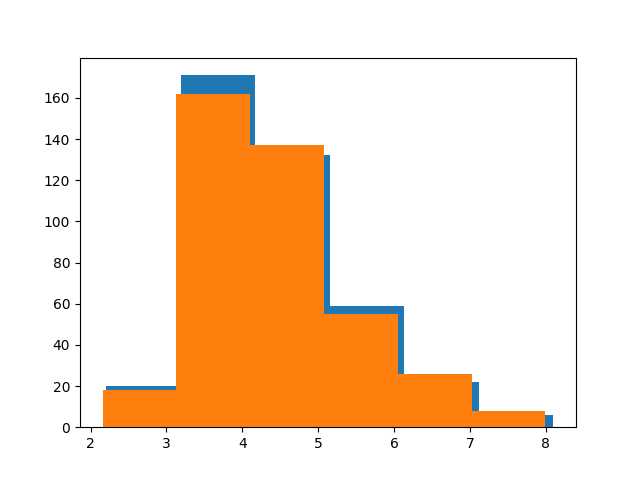

(array([ 20., 171., 132.,  59.,  22.,   6.]),
 array([2.20693 , 3.189401, 4.171872, 5.154343, 6.136814, 7.119285,
        8.101756], dtype=float32),
 <BarContainer object of 6 artists>)

In [144]:
plt.hist(means, bins = 6)

### Full plate

In [36]:
np.min(list(medians.values()))

2.1568718

In [37]:
np.max(list(medians.values()))

7.9956446

In [25]:
bins = [[0.5, 2.5], [2.5, 4], [4, 6], [6, 12]]

Fonction de calcul de la width

In [31]:
def f_w(edge):
    if edge in medians:
        return medians[edge]
    else:
        return 0.

<IPython.core.display.Javascript object>


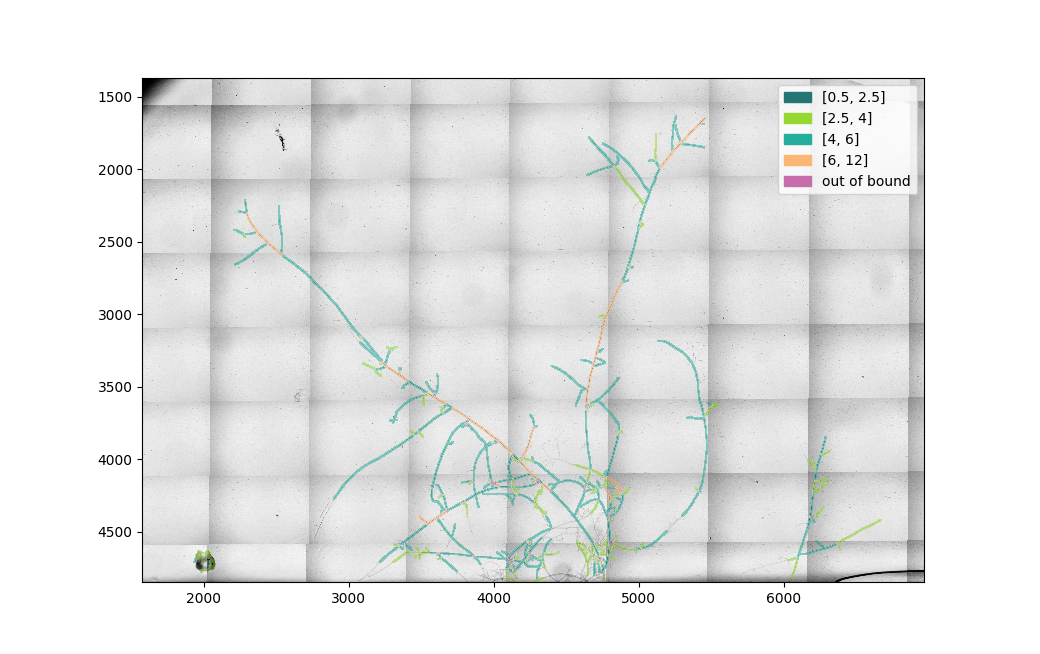

<IPython.core.display.Javascript object>


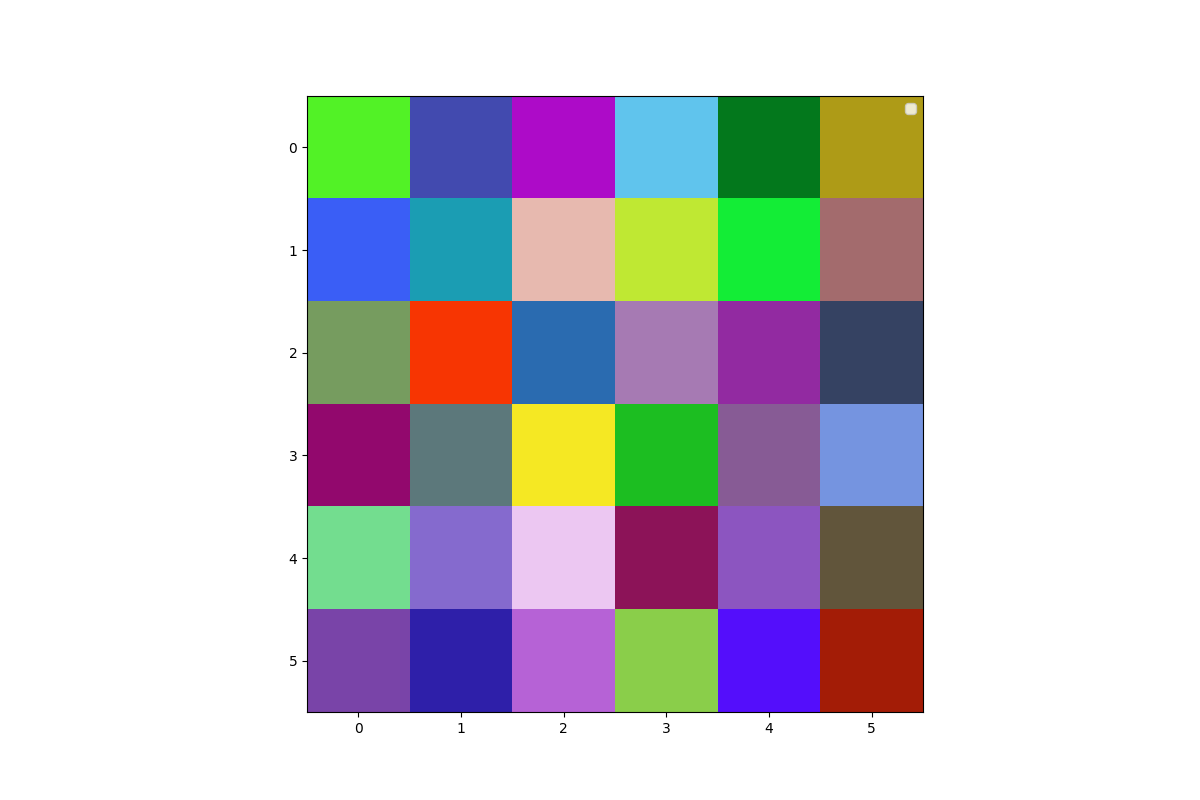

2022-06-20 18:51:05,197-[WARNING]- matplotlib.legend:1217 -> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [100]:
%matplotlib notebook
plot_edge_width(exp, 0, width_fun = f_w, intervals = bins, dilation = 15, color_seed = 100)

## Brouillon

In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
%reload_ext autoreload

In [40]:
from amftrack.util.plot import make_random_color

In [74]:
def convert(c):
    c_ = c/255
    return (c_[0], c_[1], c_[2])

In [117]:
def plot_nuancier(n = 10):
    im = np.full((1, n, 4), fill_value = 1)
    for i in range(n):
        im[0, i, :] = make_random_color((i))
    plt.imshow(im)

In [70]:
convert(make_random_color(1))

(34, 145, 216)

<IPython.core.display.Javascript object>


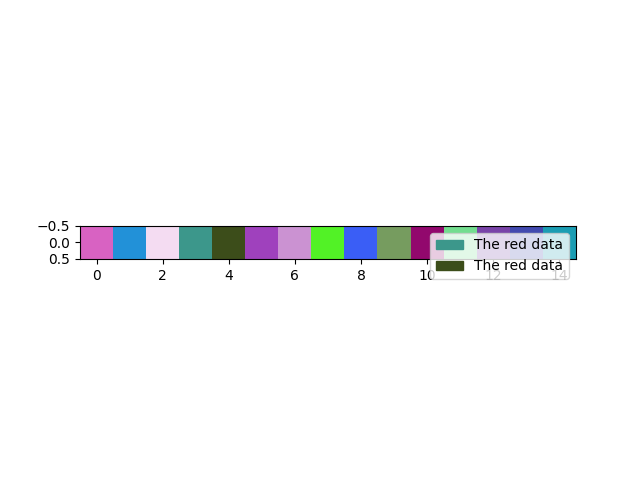

In [116]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
red_patch1 = mpatches.Patch(color=convert(make_random_color(3)), label='The red data')
red_patch2 = mpatches.Patch(color=convert(make_random_color(4)), label='The red data')
ax.legend(handles=[red_patch1, red_patch2])

plt.show()